# Importing Libraries

In [1]:
import os
import time
import pickle
import numpy as np
import pandas as pd
from numpy.linalg import norm
from tqdm import tqdm, tqdm_notebook
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50, preprocess_input

# Extracting Features from Images

In [3]:
#Initialize Model
model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

#Define Function to extract Features
def extract_features(img_path, model):
    
    #Preprocessing Input Image
    input_shape = (224, 224, 3)
    img = image.load_img(img_path, target_size=(input_shape[0], input_shape[1])) #Reshape input image size into target size
    img_array = image.img_to_array(img)
    expanded_img_array = np.expand_dims(img_array, axis=0)
    preprocessed_img = preprocess_input(expanded_img_array)
    
    #Getting features from the Image
    features = model.predict(preprocessed_img)
    flattened_features = features.flatten()
    normalized_features = flattened_features / norm(flattened_features)
    return normalized_features

94773248/94765736 [==============================] - 4s 0us/step


****Explaination of the above code:****

1.  This loads an image and resizes the image to (224, 224): img = image.load_img(img_path, target_size=(224, 224))

2.  The img_to_array() function adds channels: x.shape = (224, 224, 3) for RGB and (224, 224, 1) for gray image:          x = image.img_to_array(img) 

3.  expand_dims() is used to add the number of images: x.shape = (1, 224, 224, 3): x = np.expand_dims(x, axis=0)

4.  preprocess_input subtracts the mean RGB channels of the imagenet dataset. This is because the model you are using has     been trained on a different dataset: x.shape is still (1, 224, 224, 3): x = preprocess_input(x)

* **numpy.linalg.norm**: This function returns one of the seven matrix norms or one of the infinite vector norms depending upon the value of its parameters.
* **preprocess_input**: The preprocess_input function is meant to adequate your image to the format the model requires.Some models use images with values ranging from 0 to 1. Others from -1 to +1. Others use the "caffe" style, that is not normalized, but is centered.

In [4]:
#Find Images in the Root Directiry and making list of those Images
extensions = ['.jpg', '.JPG', '.jpeg', '.JPEG', '.png', '.PNG']
def get_file_list(root_dir):
    file_list = []
    counter = 1
    for root, directories, filenames in os.walk(root_dir):
        for filename in filenames:
            if any(ext in filename for ext in extensions):
                file_list.append(os.path.join(root, filename))
                counter += 1
    return file_list

In [5]:
# path to the datasets
root_dir = '../input/caltech101/Caltech101/Caltech101/train'
filenames = sorted(get_file_list(root_dir))

In [6]:
#Extracting Features from each Image and saving them in a list
feature_list = []
for i in tqdm_notebook(range(len(filenames))):
    feature_list.append(extract_features(filenames[i], model))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  This is separate from the ipykernel package so we can avoid doing imports until


In [7]:
#Making pickle file of filenames and features of each files for future references
pickle.dump(feature_list, open('./features-caltech101-resnet.pickle', 'wb'))
pickle.dump(filenames, open('./filenames-caltech101.pickle','wb'))

In [8]:
#Getting filenames and features from pickle files
filenames = pickle.load(open('./filenames-caltech101.pickle', 'rb'))
feature_list = pickle.load(open('./features-caltech101-resnet.pickle', 'rb'))

In [9]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory('../input/caltech101/Caltech101/Caltech101/train',
                                                   class_mode='categorical')

Found 6162 images belonging to 101 classes.


In [10]:
print(train_generator.filenames[0])

Faces/image_0001.jpg


In [11]:
#Extracting image name and labels of each Image to make a dataframe that can be used later while using annoy

file_names = []
labels = []
for files in train_generator.filenames:
    file = files.split('/')[1]
    label = files.split('/')[0]
    file_names.append(file)
    labels.append(label)

In [12]:
#Forming dataframe containing Image Id, Features of Images and Labels of the Images\
df = pd.DataFrame({'img_id':file_names, 'img_repr': feature_list, 'label': labels})

In [13]:
df.head()

,img_id,img_repr,label
0,image_0001.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Faces
1,image_0003.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Faces
2,image_0005.jpg,"[0.0, 0.0, 0.0, 0.008832973, 0.0, 0.0, 0.0, 0....",Faces
3,image_0006.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",Faces
4,image_0007.jpg,"[0.0, 0.0, 0.0, 0.0028253994, 0.0, 0.0, 0.0, 0...",Faces


# Using Spotify's Annoy for Similarity Search

In [14]:
len(df['img_repr'][0])

100352

In [15]:
from annoy import AnnoyIndex
import random

f = len(df['img_repr'][0])
t = AnnoyIndex(f, metric='euclidean')

for i in tqdm(range(len(feature_list))):
    t.add_item(i, feature_list[i])
    
_ = t.build(150)

100%|██████████| 6162/6162 [03:26<00:00, 29.77it/s]


****Explaination of the above code:****

* In this first part, we set the number of dimensions of the space of our net to number of features extracted from image i.e. **100352** and we choose to use an euclidean distance.
* Then, in the next step, we create a **6162** items i.e. equal to total number of images, each one with its correspondenly **100352** dimensional vector, which can be also understood as a point in a 100352th dimensional space.
* We build then the corresponding net by using 1000 trees.

In [47]:
#Defining function to get similar images output in dataframe of the base image index we give as parameter

def get_similar_images_annoy(img_index):
    start = time.time()
    base_img_id, base_vector, base_label  = df.iloc[img_index, [0, 1, 2]]
    similar_img_ids = t.get_nns_by_item(img_index, 4)
    end = time.time()
    # Now we want to get the 5 elements sorted by its euclidean distance relative to the image indexed item
    print(f'{(end - start) * 1000} ms')
    return base_img_id, base_label, df.iloc[similar_img_ids[1:]]

In [71]:
#Querying the AnnoyIndex    
base_image, base_label, similar_images_df = get_similar_images_annoy(4000)

261.0921859741211 ms


In [72]:
print('Base Image Id:', base_image)
print('Base Image Label:', base_label)

Base Image Id: image_0042.jpg
Base Image Label: ibis


In [73]:
#Dataframe of similar images
similar_images_df.head()

,img_id,img_repr,label
4008,image_0051.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ibis
3972,image_0004.jpg,"[0.0, 0.0, 0.0017034006, 0.0, 0.0, 0.0, 0.0, 0...",ibis
3978,image_0011.jpg,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",ibis


# Plotting Base and Similar Images

In [74]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2 as cv

In [75]:
def show_images(root_dir):
    plt.figure(figsize = (16,9))
    
    plt.subplot(1,4,1)
    path = os.path.join(root_dir, base_label, base_image)
    image = mpimg.imread(path)
    plt.imshow(image)
    plt.title('Base Image')
    plt.axis('off')
    
    for i in range(len(similar_images_df)):
        path = os.path.join(root_dir, similar_images_df.iloc[i,2],similar_images_df.iloc[i,0])
        image = mpimg.imread(path)
        plt.subplot(1,4,i+2)
        plt.imshow(image)
        plt.title('Similar Image')
        plt.axis('off')

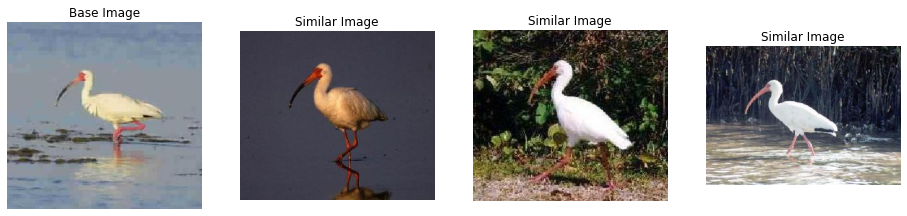

In [76]:
root_dir = '../input/caltech101/Caltech101/Caltech101/train'
show_images(root_dir)